In [1]:
using LinearAlgebra, Plots, BenchmarkTools

### MATH50003 Week 5 Notes

Cholesky decomposition: only relevant for symmetric positive defininte matrices.

**Proposition** If $A \in \mathbb{R}^{nxn}$ is positive definite, and $V \in \mathbb{R}^{nxn}$ is nonn-sigular, then $$V^TAV$$ is positive definite.

**Proposition** A matrix is symmetric positive definite if and only if it has a Cholesky decomposition $$A=LL^T$$ where the diagonals of $L$ are positive.

Different decompositions have trade-offs between speend and stability:

On my machine, cholesky is about 1x faster than lu which is about 4x faster than QR.

In terms of stability, QR computed with Householder reflections and Cholesky are stable, LU is usually unstable unless the matrix is diagonally donminant.

In [7]:
n = 100
A = Symmetric(randn(n,n)) + 100I # Shift by 100 ensures positivity on the diagonal entries

@btime cholesky(A);
@btime lu(A);
@btime qr(A);

  31.895 μs (5 allocations: 78.25 KiB)
  61.679 μs (4 allocations: 79.08 KiB)
  243.362 μs (7 allocations: 134.55 KiB)


It is worth noticing that PLU is ustable in theory, but the set of matrices for which it is unstable is extremely smalle, so small one does not normally run into them.

Here is an example matrix that is in this set:

In [10]:
function badmatrix(n)
    A = Matrix(1I, n, n) # n by n matrix with the diagonal entries all being 1
    A[:, end] .= 1
    for j = 1:n-1
        A[j+1:end, j] .= -1
    end
    A
end
A = badmatrix(5)

5×5 Matrix{Int64}:
  1   0   0   0  1
 -1   1   0   0  1
 -1  -1   1   0  1
 -1  -1  -1   1  1
 -1  -1  -1  -1  1

In [11]:
L,U = lu(A)

LU{Float64, Matrix{Float64}}
L factor:
5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0  0.0
 -1.0   1.0   0.0   0.0  0.0
 -1.0  -1.0   1.0   0.0  0.0
 -1.0  -1.0  -1.0   1.0  0.0
 -1.0  -1.0  -1.0  -1.0  1.0
U factor:
5×5 Matrix{Float64}:
 1.0  0.0  0.0  0.0   1.0
 0.0  1.0  0.0  0.0   2.0
 0.0  0.0  1.0  0.0   4.0
 0.0  0.0  0.0  1.0   8.0
 0.0  0.0  0.0  0.0  16.0

We can see that the last column of U is growing exponentially fast, thus when n is large, we get very large errors. Yet qr is completely fine with this:

In [32]:
n = 100
b = randn(n)

# compare PLU and QR
A = badmatrix(n)
norm(A\b -qr(A)\b) # If A is square, \ does inversion using PLU by default; if rectangular, \ does least squares using QR.

4.120684214119952

In [33]:
norm(qr(A)\b - qr(big.(A))\b) # Roughly machine epsilon, big.(A) is to generate more exact results by increasing precision.

8.454228853680990543852244135885805925623567096175700390414157059546877871502638e-15

### Question of Cholesky

`SymTridiagonal(dv, eu)` is a type for representing symmetric tridiagonal
matrices (that is, `SymTridiagonal(dv, ev) == Tridiagonal(ev, dv, ev)`). Complete the following
implementation of `cholesky` to return a `Bidiagonal` cholesky factor in $O(n)$ operations

In [37]:
using LinearAlgebra
import LinearAlgebra: cholesky

# return a Bidiagonal L such that L'L == A (up to machine precision)
cholesky(A::SymTridiagonal) = cholesky!(copy(A))

# return a Bidiagonal L such that L'L == A (up to machine precision)
# You are allowed to change A
function cholesky!(A::SymTridiagonal)
    d = A.dv # diagonal entries of A
    u = A.ev # sub/super-diagonal entries of A
    T = float(eltype(A)) # return type, make float in case A has Ints
    n = length(d)
    ld = zeros(T, n) # diagonal entries of L
    ll = zeros(T, n-1) # sub-diagonal entries of L

    # TODO: populate ld and ll
    ld[1] = sqrt(d[1])
    for k = 1:n-1
        ll[k] = u[k] / ld[k]
        ld[k+1] = sqrt(d[k+1] - ll[k]^2)
    end
    Bidiagonal(ld, l, :L)
end

cholesky! (generic function with 1 method)

### Singular values and condition number

The matrix 2-norm ivolves singular values, which are a measure of how matrices 'stretch' vectors. 

And the singular values will give a notion of a condition number, which allow us to bound errors.

In [20]:
using LinearAlgebra, Plots

**Definition (p-norm)**
For $1 ≤ p < ∞$ and $𝐱 \in ℝ^n$, define the $p$-norm:
$$
\|𝐱\|_p := \left(\sum_{k=1}^n |x_k|^p\right)^{1/p}
$$
where $x_k$ is the $k$-th entry of $𝐱$. 
For $p = ∞$ we define
$$
\|𝐱\|_∞ := \max_k |x_k|
$$

In [25]:
norm([1,-2,3]) == norm([1,-2,3], 2) == sqrt(1^2 + 2^2 + 3^2),
norm([1,-2,3], 1) == 1+2+3,
norm([1,-2,3], Inf) == 3

(true, true, true)


 Matrices have norms that measure their "length".  
 
 **Fröbenius norm**, defined for an $m \times n$ real matrix $A$ as
$$
\|A\|_F := \sqrt{\sum_{k=1}^m \sum_{j=1}^n A_{kj}^2}
$$
This is available as `norm` in Julia:

In [27]:
A = randn(5,3)
norm(A) == norm(vec(A))

true

**Matrix-norm**

Suppose $A ∈ ℝ^{m × n}$  and consider two norms $\| ⋅ \|_X$ on $ℝ^n$  and 
$\| ⋅ \|_Y$ on $ℝ^n$. Define the _(induced) matrix norm_ as:
$$
\|A \|_{X → Y} := \sup_{𝐯 : \|𝐯\|_X=1} \|A 𝐯\|_Y
$$
Also define
$$
\|A\|_X \triangleq \|A\|_{X \rightarrow X}
$$

Note an equivalent definition of the induced norm:
$$
\|A\|_{X → Y} = \sup_{𝐱 ∈ ℝ^n, 𝐱 ≠ 0} {\|A 𝐱\|_Y \over \| 𝐱\|_X}
$$
This follows since we can scale $𝐱$ by its norm so that it has unit norm, that is,
${𝐱} \over \|𝐱\|_X$ has unit norm.

**$1$-norm** 
$$
\|A \|_1 = \max_j \|𝐚_j\|_1
$$
that is, the maximum $1$-norm of the columns. 

**supremum-norm**
$$
\|A\|_∞ = \max_k \|A[k,:]\|_1
$$
that is, the maximum $1$-norm of the rows.

In Julia, Matrix norms are available via `opnorm`.

In [30]:
m, n = 5, 3
A = randn(m, n)
opnorm(A, 1) == maximum(norm(A[:,j],1) for j = 1:n),
opnorm(A, Inf) == maximum(norm(A[k,:],1) for k = 1:m),
opnorm(A)

(true, true, 2.686433881649128)

**Proposition (diagonal/orthogonal 2-norms)** If $Λ$ is diagonal with entries $λ_k$ then
$\|Λ\|_2 = \max_k |λ_k|.$. If $Q$ is orthogonal then $\|Q\| = 1$.

### Singular Value Decomposition

For $A ∈ ℝ^{m × n}$ with rank $r > 0$, 
the _reduced singular value decomposition (SVD)_ is
$$
A = U Σ V^⊤
$$
where $U ∈ ℝ^{m × r}$ and $V ∈  ℝ^{r × n}$ have orthonormal columns and $Σ ∈ ℝ^{r × r}$ is  diagonal whose
diagonal entries, which we call _singular values_, are all positive and decreasing: $σ_1 ≥ ⋯ ≥ σ_r > 0$.

**Corollary (singular values and norm)**
$$
\|A \|_2 = σ_1
$$
and if $A ∈ ℝ^{n × n}$ is invertible, then
$$
\|A^{-1} \|_2 = σ_n^{-1}
$$

**Theorem (best low rank approximation)** The  matrix
$$
A_k := \begin{bmatrix} 𝐮_1 | ⋯ | 𝐮_k \end{bmatrix} \begin{bmatrix}
σ_1 \\
& ⋱ \\
&& σ_k\end{bmatrix} \begin{bmatrix} 𝐯_1 | ⋯ | 𝐯_k \end{bmatrix}^⊤
$$ 
is the best 2-norm approximation of $A$ by a rank $k$ matrix, that is, for all rank-$k$ matrices $B$, we have 
$$\|A - A_k\|_2 ≤ \|A -B \|_2.$$

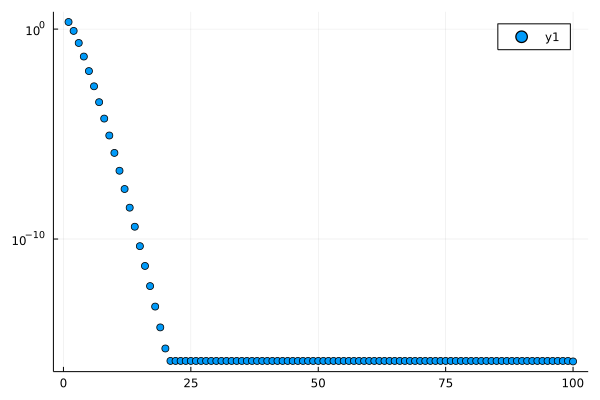

In [35]:
# Example by considering hilbert matrix
function hilbertmatrix(n)
    ret = zeros(n,n)
    for j = 1:n, k=1:n
        ret[k,j] = 1 / (k+j-1)
    end
    ret
end

H = hilbertmatrix(100)
U, σ, V = svd(H)
scatter(σ; yscale=:log10)

In [36]:
# Notice that typically we do not get an exactly zero singular values, so rank is always treated as min(m,n).
# In this case, we can approximate the matrix very well by a rank 20 matrix
k = 20
∑_k = Diagonal(σ[1:k])
U_k = U[:,1:k]
V_k = V[:,1:k]
norm(U_k * ∑_k * V_k' - H)

1.15531964884547e-15

### Example Question of Singular value decomposition

Consider functions sampled on a $(n+1) × (n+1)$ 2D grid 
$(x_k,y_j) = (k/n, j/n)$ where $k,j = 0,…,n$. 
For $n = 100$, what is the lowest rank $r$ such that
the  best rank-$r$ approximation to the samples 
that is accurate to within $10^{-5}$ accuracy for the following functions:
$$
(x + 2y)^2, \cos(\sin x {\rm e}^y), 1/(x + y + 1), \hbox{sign}(x-y)
$$
For which examples does the answer change when $n = 1000$?

In [39]:
# Define function
f1(x,y) = (x + 2*y)^2
f2(x,y) = cos(sin(x) * exp(y))
f3(x,y) = 1/(x + y + 1)
f4(x,y) = sign(x - y)

# Define error
error = 1e-5

# Compute nxn samples
function samples(f,n)
    x = y = range(0,1; length=n) # x and y will both be (10,) vectors
    return f.(x,y') # Notice we need to take the transpose of y, and use f.() to broadcast. The output will be a 10 by 10 matrix.
end

samples (generic function with 1 method)

In [60]:
function find_min_rank(f, n, ϵ)
    F = samples(f,n)
    U, σ, V = svd(F)
    for k = 1:n
        ∑_k = Diagonal(σ[1:k])
        U_k = U[:,1:k]
        V_k = V[:,1:k]
        if norm(U_k * ∑_k * V_k' - F) ≤ ϵ
            return k
        end
    end
end

find_min_rank (generic function with 1 method)

In [61]:
n=100
println("Error ≤ ", error, " with n = ", n)
println("Rank for f₁ = ", find_min_rank(f1, n, error))
println("Rank for f₂ = ", find_min_rank(f2, n, error))
println("Rank for f₃ = ", find_min_rank(f3, n, error))
println("Rank for f₄ = ", find_min_rank(f4, n, error))


n=1000
println("Error ≤ ", error, " with n = ", n)
println("Rank for f₁ = ", find_min_rank(f1, n, error))
println("Rank for f₂ = ", find_min_rank(f2, n, error))
println("Rank for f₃ = ", find_min_rank(f3, n, error))
println("Rank for f₄ = ", find_min_rank(f4, n, error))

Error ≤ 1.0e-5 with n = 100
Rank for f₁ = 3
Rank for f₂ = 5
Rank for f₃ = 4
Rank for f₄ = 100
Error ≤ 1.0e-5 with n = 1000
Rank for f₁ = 3
Rank for f₂ = 5
Rank for f₃ = 5
Rank for f₄ = 1000
